# Zonal wind response: tropical, midlatitude and polar cloud impacts

This script generates figure 5: maps of the impacts of tropical, midlatitude and polar cloud changes on the zonal wind response in ICON.

### Load libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import helper_functions as fct

### Load own colorbar

In [2]:
mymap, mymap2 = fct.generate_mymap()

### Specify months and seasons of the year

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
seasons = ['DJF', 'MAM', 'JJA', 'SON']

### Specify simulations that are analyzed and impacts that are calculated (total response, SST impact, global cloud impact, regional cloud impacts)

In [4]:
# simulations with global cloud changes
runs_glo = ['T1C1', 'T2C2', 'T2C1', 'T1C2']

# simulations with regional cloud changes
runs_reg_TR = ['T1C2TR', 'T1C1TR', 'T2C2TR', 'T2C1TR']
runs_reg_ML = ['T1C2ML', 'T1C1ML', 'T2C2ML', 'T2C1ML']
runs_reg_PO = ['T1C2PO', 'T1C1PO', 'T2C2PO', 'T2C1PO']

runs_reg = runs_reg_TR + runs_reg_ML + runs_reg_PO
runs_all = runs_glo + runs_reg

# responses
response_all = ['total', 'SST', 'cloud',
                'cloud TR', 'cloud notTR',
                'cloud ML', 'cloud notML',
                'cloud PO', 'cloud notPO']

### Read zonal wind at 850 hPa

In [5]:
u850 = {}
ipath = '../../ICON-NWP_lockedclouds/'
for run in runs_all:
    print('reading ' + run)
    ifile = 'ICON-NWP_AMIP_' + run + '_3d_mm.nc'
    ncfile = nc.Dataset(ipath + ifile, 'r')
    lats = np.array(ncfile.variables['lat'][:].data)
    lons = np.array(ncfile.variables['lon'][:].data)
    levs = np.array(ncfile.variables['lev'][:].data)
    uwind = np.array(ncfile.variables['u'][:].data)
    ncfile.close()
    # get zonal wind at 850 hPa
    levind850 = (np.abs(levs-85000)).argmin() # find index of 850 hPa level
    u850[run] = uwind[:, levind850, :, :]
    del levs, uwind, levind850
    del ifile, ncfile
del run

reading T1C1
reading T2C2
reading T2C1
reading T1C2
reading T1C2TR
reading T1C1TR
reading T2C2TR
reading T2C1TR
reading T1C2ML
reading T1C1ML
reading T2C2ML
reading T2C1ML
reading T1C2PO
reading T1C1PO
reading T2C2PO
reading T2C1PO


### Calculate DJF mean

In [6]:
print('Calculate DJF mean')
u850_djf = {}
for run in runs_all:
    u850_djf[run] = fct.calcMonthlyandSeasonMean(u850[run], months, seasons)[1]['DJF']
del run

Calculate DJF mean


### Calculate DJF jet latitude in control simulation (T1C1)

In [7]:
jetlat_sh_T1C1 = np.full(lons.shape, np.nan, dtype=float)
jetlat_nh_T1C1 = np.full(lons.shape, np.nan, dtype=float)
for i in range(lons.shape[0]):
    jetlat_sh_T1C1[i], _, jetlat_nh_T1C1[i], _ = \
       fct.get_eddyjetlatint(u850_djf['T1C1'][:, i], lats)
del i

### Calculate responses (total response, SST impact, global cloud impact, regional cloud impacts)

In [8]:
du850_djf = np.full((len(response_all), len(lats), len(lons)), np.nan,
                    dtype=float)
# total, SST, cloud
du850_djf[0, :, :], du850_djf[1, :, :], du850_djf[2, :, :] = \
  fct.calc_impacts_timmean(u850_djf['T1C1'], u850_djf['T2C2'],
                           u850_djf['T1C2'], u850_djf['T2C1'])
# regional cloud impacts
for k in range(int(len(runs_reg)/4)):
    _, _, du850_djf[k*2+3, :, :], du850_djf[k*2+4, :, :] = \
      fct.calc_3impacts_timmean(u850_djf['T1C1'], u850_djf['T2C2'],
                                u850_djf['T1C2'], u850_djf['T2C1'],
                                u850_djf[runs_all[4:][k*4]],
                                u850_djf[runs_all[4:][k*4+1]],
                                u850_djf[runs_all[4:][k*4+2]],
                                u850_djf[runs_all[4:][k*4+3]])
del k
del u850, u850_djf

### Read masks for significant responses

These masks are generated with the script "calculate_significance_bootstrapping.ipynb" based on time series of the seasonal mean zonal wind.

In [9]:
ipath_bs = '../../ICON-NWP_lockedclouds/'
du850_mask_sm_bs = np.load(ipath_bs + 'du850_mask_sm_bs.npy',
                           allow_pickle='TRUE').item()
del ipath_bs

# only store masks for tropical, midlatitude and polar cloud impacts
response_sel = ['cloud TR', 'cloud ML', 'cloud PO']
du850_djf_mask = np.array([du850_mask_sm_bs[r][seasons.index('DJF'), :, :] \
                           for r in response_sel])

del du850_mask_sm_bs

### Prepare plot

Shift the longitudes from 0deg...360deg to -90deg...270deg for visualization reasons and select the North Atlantic region (otherwise it is very slow to add the dots for the regions, in which the response is significant).


In [10]:
# shift longitudes
du850_djf_shift, lons_shift = fct.shiftgrid_copy(90., du850_djf, lons, start=False)
du850_mask_shift, _ = fct.shiftgrid_copy(90., du850_djf_mask, lons, start=False)
jetlat_nh_shift = fct.shiftgrid_copy(90., jetlat_nh_T1C1, lons, start=False)[0]

# find indices of border of North Atlantic/Europe box
# -> makes plotting faster (important if mask is plotted)
lonind_west = (np.abs(lons_shift--72)).argmin()
lonind_east = (np.abs(lons_shift-32)).argmin()
latind_sout = (np.abs(lats-28)).argmin()
latind_nort = (np.abs(lats-72)).argmin()

lons_plot = lons_shift[lonind_west:lonind_east+1]
lats_plot = lats[latind_sout:latind_nort+1]

jetlat_nh_plot = jetlat_nh_shift[lonind_west:lonind_east+1]


### Plot maps of tropical, midlatitude and polar cloud impacts

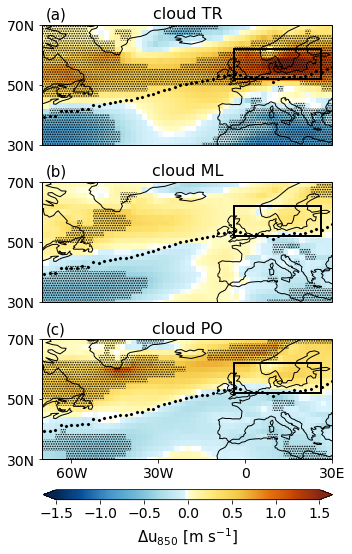

In [11]:
response_plot = ['cloud TR', 'cloud ML', 'cloud PO']

du850_plot = np.array([du850_djf_shift[response_all.index(r),
                                       latind_sout:latind_nort+1,
                                       lonind_west:lonind_east+1] \
                       for r in response_plot])
mask_plot = np.array([du850_mask_shift[response_sel.index(r),
                                       latind_sout:latind_nort+1,
                                       lonind_west:lonind_east+1] \
                      for r in response_plot])

# box around region with jet exit strengthening
#lonwest = -4; loneast = 25; latsout = 52; latnort = 61
lonwest = -4; loneast = 26; latsout = 52; latnort = 62

# plot
proj = ccrs.PlateCarree(central_longitude=-90)
fig, ax = plt.subplots(3, 1, figsize=(5, 7),#figsize(10),
                       subplot_kw=dict(projection=proj))
ax = ax.reshape(-1)
labs = ['(a)', '(b)', '(c)']
for r in range(du850_plot.shape[0]): # loop over responses
    ax[r].coastlines(rasterized=True)
    ax[r].set_aspect('auto')
    ax[r].tick_params(labelsize=14)
    # extended North Atlantic region
    ax[r].set_extent([-70, 30, 30, 70], ccrs.PlateCarree())
    # set yticks for longitudes
    ax[r].set_yticks([30, 50, 70], crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter(degree_symbol='')
    ax[r].yaxis.set_major_formatter(lat_formatter)
    del lat_formatter
    # draw box around region, for which we determine the area-mean response
    # left vertical line
    ax[r].plot([lonwest, lonwest], [latsout, latnort],
               linewidth=2, color='k', transform=ccrs.PlateCarree())
    # right vertical line
    ax[r].plot([loneast, loneast], [latsout, latnort],
               linewidth=2, color='k', transform=ccrs.PlateCarree())
    # upper horizontal line
    ax[r].plot([loneast, lonwest], [latnort, latnort],
               linewidth=2, color='k', transform=ccrs.PlateCarree())
    # lower horizontal line
    ax[r].plot([lonwest, loneast], [latsout, latsout],
               linewidth=2, color='k', transform=ccrs.PlateCarree())
    # jet latitude in control run
    ax[r].plot(lons_plot, jetlat_nh_plot, marker='x',
               color='k', linestyle='none', markeredgewidth=2,
               markersize=2, transform=ccrs.PlateCarree())
    # plot different effects
    cf0 = ax[r].pcolormesh(lons_plot, lats_plot,
                           du850_plot[r, :, :],
                           vmin=-1.5, vmax=1.5, cmap=mymap2,
                           rasterized=True,
                           transform=ccrs.PlateCarree())
    # stippling for significance
    ax[r].pcolor(lons_plot, lats_plot,
                 np.ma.masked_values(1*mask_plot[r, :, :], 0),
                 hatch='.....', alpha=0.,
                 rasterized=True,
                 transform=ccrs.PlateCarree())
    ax[r].set_title(response_plot[r][0:8], fontsize=16)
    # a), b) etc for subplots
    ax[r].text(0.01, 1.02, labs[r], va='bottom', ha='left',
                      rotation_mode='anchor', fontsize=15,
                      transform=ax[r].transAxes)
del r
# xaxis: longitudes
ax[2].set_xticks([-60, -30, 0, 30], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(#zero_direction_label=True,
                                    degree_symbol='',
                                    dateline_direction_label=True)
ax[2].xaxis.set_major_formatter(lon_formatter)
del lon_formatter

fig.canvas.draw()
fig.tight_layout()

# colorbar for response
#clevs = [-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5]
fig.subplots_adjust(bottom=0.08)#(right=0.8)
cbar_ax = fig.add_axes([0.13, 0.0, 0.804, 0.02]) # left,bottom,width,height
cb = fig.colorbar(cf0, cax=cbar_ax, orientation='horizontal', extend='both')#,
                  #ticks=clevs)
cb.set_label('$\Delta$u$_{850}$ [m s$^{-1}$]', fontsize=15, labelpad=5)
cb.ax.tick_params(labelsize=14)
del cbar_ax, cb, cf0#, clevs

fig.savefig('figure5a_5c.pdf', dpi=200, bbox_inches='tight')
plt.show(fig)
plt.close(fig)
del fig, ax, proj
del response_plot, du850_plot, mask_plot
del lonwest, loneast, latsout, latnort